In [1]:
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from surface_dice import SurfaceDiceMetric
import albumentations as A
import random
import segmentation_models_pytorch as smp
from math import ceil
from patcher import Patcher

device = "cuda" if torch.cuda.is_available() else "cpu"
input_dir = "/kaggle/input/blood-vessel-segmentation/"
train_dir = input_dir + "train/"

# reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
net = smp.Unet(
    encoder_name="timm-mobilenetv3_small_075",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
net.load_state_dict(torch.load("baseline.pth"))
net.to(device)
net.eval();

In [3]:
class KidneyDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_dir, msks_dir, slices_ids, transforms=None):
        self.imgs_dir = imgs_dir
        self.msks_dir = msks_dir
        self.slices_ids = slices_ids
        self.transforms = transforms
        self.h = Image.open(imgs_dir + slices_ids[0]).height
        self.w = Image.open(imgs_dir + slices_ids[0]).width

    def __len__(self):
        return len(self.slices_ids)

    def __getitem__(self, idx):
        slice_id = self.slices_ids[idx]
        img_path = self.imgs_dir + slice_id
        msk_path = self.msks_dir + slice_id

        img = Image.open(img_path)
        msk = Image.open(msk_path)
        img = np.array(img, dtype=np.float32)
        msk = np.array(msk)

        if self.transforms is not None:
            t = self.transforms(image=img, mask=msk)
            img = t["image"]
            msk = t["mask"]
            
        img = torch.from_numpy(img)[None, :]
        msk = torch.as_tensor(msk, dtype=torch.float32)
        img /= img.max() # [0, 1] range, hopefully max is not 0
        msk /= 255 # {0, 1} values

        return img, msk

In [4]:
imgs_dir = f"{train_dir}kidney_1_dense/images/"
msks_dir = f"{train_dir}kidney_1_dense/labels/"
slices_ids = ["1028.tif"]

patch_size = 224
transforms = A.Compose(
    [
        A.RandomCrop(patch_size, patch_size)
    ]
)

ds = KidneyDataset(
    imgs_dir=imgs_dir,
    msks_dir=msks_dir,
    slices_ids=slices_ids,
)

In [5]:
x, y = ds[0]
x, y = x.unsqueeze(1).to(device), y.to(device)

print(x.shape)
print(y.shape)


torch.Size([1, 1, 1303, 912])
torch.Size([1303, 912])


In [6]:
h, w = x.shape[-2:]
overlap = 50
patcher = Patcher(h, w, patch_size=patch_size, overlap=overlap)

In [7]:
x = patcher.extract_patches(x)  # (bs, n_patches, h, w)
with torch.no_grad():
    logits = net(x.reshape(-1, 1, patch_size, patch_size))  # (bs * n_patches, 1, patch_size, patch_size)
    logits = logits.view(1, -1, patch_size, patch_size)  # (bs, n_patches, patch_size, patch_size)
    logits = patcher.merge_patches(logits).squeeze()  # (bs, h, w)

In [11]:
probs = logits.sigmoid().cpu()

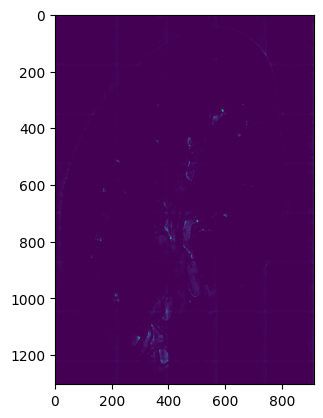

In [14]:
plt.imshow(probs)